# Continuous Control -> SAC with entropy maximization
# REACHER

---

This notebook implements the Soft Actor-Critic Algorithm as documented in the paper [here](https://arxiv.org/pdf/1812.05905.pdf)

Useful references
[berkeley repository](https://github.com/rail-berkeley/softlearning/blob/master/softlearning/algorithms/sac.py)

In [1]:
#Simulation parameters

train_mode = True #test mode if False
load_mode=False #set it to True in test mode (train_mode = False)
save_mode = True #save the networks - train_mode only

#Task parameters

state_dim = 33
action_dim = 4
solve_score = 30.0

# Key Hyperparameters for simulation-purpose
auto_entropy_tuning = True

if auto_entropy_tuning==False:
    alpha = 0.0035

single_q = False # this parameter is used to test the influence of the double Q minimization trick

# Gemeral Hyperparameters
layer_size=128
weights_init_bound = 0.999
replay_buffer_size=50000
num_epochs=1000
num_steps_per_epoch=1000
batch_size=256
discount=0.99
soft_target_tau=0.02
target_update_period=1

policy_lr=0.0003
qf_lr=0.001
a_lr = 0.001

update_every = 1
episods_before_learning = 10

first_30 = 0

In [2]:
# Import libraries
from IPython.display import clear_output

import random
import math
from collections import namedtuple, deque

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# CPU / GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Launch the environment
env = UnityEnvironment(file_name="Reacher.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=train_mode)[brain_name]      # reset the environment

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
#print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
#print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
#print('The state for the first agent looks like:', states[0])


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1


In [4]:
class SoftAgent(nn.Module):
    
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super(SoftAgent, self).__init__()
        
        # state, hidden layer, action sizes
        self.input_size = input_size
        self.h1_size = h1_size
        self.h2_size = h2_size
        self.output_size = output_size
        
        # define layers
        self.fc1 = nn.Linear(self.input_size, self.h1_size)
        self.fc2 = nn.Linear(self.h1_size, self.h2_size)
        self.fc3 = nn.Linear(self.h2_size, self.output_size)
        
        #initialize weights
        init_w = 3e-3
        self.fc3.weight.data.uniform_(-init_w,init_w)
        self.fc3.bias.data.uniform_(-init_w,init_w)            
        
    def forward(self, state,action):
        x = torch.cat([state,action],1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class GaussianPolicy(nn.Module):

    def __init__(self, input_size, h1_size, h2_size, output_mean_size, output_std_size):
        super(GaussianPolicy, self).__init__()
        
        # state, hidden layer, action sizes
        self.input_size = input_size
        self.h1_size = h1_size
        self.h2_size = h2_size
        self.output_mean_size = output_mean_size
        self.output_std_size = output_std_size
        # define layers
        self.fc1 = nn.Linear(self.input_size, self.h1_size)
        self.fc2 = nn.Linear(self.h1_size, self.h2_size)
        self.fc3_mean = nn.Linear(self.h2_size, self.output_mean_size)
        self.fc3_log_std = nn.Linear(self.h2_size, self.output_std_size)
        #initialize weights
        init_w = 3e-3
        self.fc3_mean.weight.data.uniform_(-init_w,init_w)
        self.fc3_mean.bias.data.uniform_(-init_w,init_w)
        self.fc3_log_std.weight.data.uniform_(-init_w,init_w)
        self.fc3_log_std.bias.data.uniform_(-init_w,init_w)
                        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.fc3_mean(x) #values of the action should be between -1 and 1 so this is not the mean of the action value
        log_std = self.fc3_log_std(x)
        log_std_min = -20
        log_std_max = 0
        log_std = torch.clamp(log_std,log_std_min, log_std_max)              
        return mean,log_std
    
    def sample (self,state,epsilon = 1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal (mean,std)
        z = normal.rsample()
        action = torch.tanh(z) 
        log_pi = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_pi = log_pi.sum(1,keepdim=True)
        return action, log_pi
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()   
        normal = Normal(mean, std)
        z = normal.sample() #sample an action from a normal distribution with (mean,std)
        action = torch.tanh(z) #squeeze the value between -1 and 1
        action = action.cpu().detach().squeeze(0).numpy()
        return self.rescale_action(action)
    
    def get_action2(self, state): #used for testing purpose - we remove the stochasticity of the sampling step
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        action = torch.tanh(mean)
        action = action.cpu().detach().squeeze(0).numpy()
        return self.rescale_action(action)
    
    def rescale_action(self, action):
        action_range=[-1,1]
        return action * (action_range[1] - action_range[0]) / 2.0 +\
            (action_range[1] + action_range[0]) / 2.0

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        #dones = dones.view(dones.size(0), -1)
        return (states, actions, rewards, next_states, dones)

    def buffer_len(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
qf1 = SoftAgent(
    input_size = state_dim + action_dim,
    h1_size = layer_size,
    h2_size = layer_size,
    output_size=1
).to(device)
qf1_optimizer = optim.Adam(qf1.parameters(), lr=qf_lr)

qf2 = SoftAgent(
    input_size = state_dim + action_dim,
    h1_size = layer_size,
    h2_size = layer_size,
    output_size=1
).to(device)
qf2_optimizer = optim.Adam(qf2.parameters(), lr=qf_lr)

target_qf1 = SoftAgent(
    input_size = state_dim + action_dim,
    h1_size = layer_size,
    h2_size = layer_size,
    output_size=1
).to(device)

target_qf2 = SoftAgent(
    input_size = state_dim + action_dim,
    h1_size = layer_size,
    h2_size = layer_size,
    output_size=1
).to(device)

policy = GaussianPolicy(
    input_size = state_dim,
    h1_size = layer_size,
    h2_size = layer_size,
    output_mean_size = action_dim,
    output_std_size = action_dim
).to(device)
policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)

replay_buffer = ReplayBuffer(replay_buffer_size, batch_size, 1)

if auto_entropy_tuning:    
    target_entropy = -0.000
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha = log_alpha.exp()
    log_alpha_optim = optim.Adam([log_alpha], lr=a_lr)

In [8]:
if load_mode:
    qf1.load_state_dict(torch.load('checkpoint_qf1.pth'))
    qf1.eval()
    
    qf2.load_state_dict(torch.load('checkpoint_qf2.pth'))
    qf2.eval()
    
    policy.load_state_dict(torch.load('checkpoint_policy.pth'))
    policy.eval()

In [9]:
# copy parameters of qf1 to target_qf1

for target_params, params in zip(target_qf1.parameters(), qf1.parameters()):
    target_params.data.copy_(params)

for target_params, params in zip(target_qf2.parameters(), qf2.parameters()):
    target_params.data.copy_(params)

In [10]:
def update():
    
    global alpha
    global log_alpha
    global update_step
    delay_step = 1
    global soft_target_tau
    
    states, actions,rewards, next_states, dones = replay_buffer.sample() #returns torch tensors

    # POLICY EVALUATION STEP
    #Update the Q-function parameters

    next_actions, next_log_pis = policy.sample(next_states)

    next_qf1 = target_qf1.forward(next_states,next_actions)
    next_qf2 = target_qf2.forward(next_states,next_actions)

    if single_q:
        next_q_target = next_qf1 - alpha * next_log_pis
    else:
        next_q_target = torch.min(next_qf1,next_qf2) - alpha * next_log_pis

    expected_q = rewards + (1 - dones) * discount * next_q_target

    curr_qf1 = qf1.forward(states,actions)
    curr_qf2 = qf2.forward(states,actions)

    qf1_loss = F.mse_loss(curr_qf1, expected_q.detach())
    qf2_loss = F.mse_loss(curr_qf2, expected_q.detach())

    qf1_optimizer.zero_grad()
    qf1_loss.backward()
    qf1_optimizer.step()

    qf2_optimizer.zero_grad()
    qf2_loss.backward()
    qf2_optimizer.step()

    # POLICY IMPROVEMENT STEP
    new_actions,log_pi = policy.sample(states)
    if update_step % delay_step ==0:
        min_q = torch.min(qf1.forward(states, new_actions),
                          qf2.forward(states, new_actions))
        #alpha = log_alpha.exp()
        policy_loss = (alpha * log_pi - min_q).mean()
        
        #Update policy weights
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        #Update target network weights at every iteration

        for target_params, params in zip(target_qf1.parameters(), qf1.parameters()):
            target_params.data.copy_(soft_target_tau * params + (1 - soft_target_tau) * target_params)

        for target_params, params in zip(target_qf2.parameters(), qf2.parameters()):
            target_params.data.copy_(soft_target_tau * params + (1 - soft_target_tau) * target_params)
    
    #Adjust entropy temperature
    if auto_entropy_tuning:    
        log_alpha_optim.zero_grad()
        alpha_loss = (log_alpha * (-log_pi - target_entropy).detach()).mean()
        alpha_loss.backward()
        log_alpha_optim.step()
        alpha = log_alpha.exp()

Episode 130	Last Score: 38.97; average score: 30.18; alpha: 0.0017

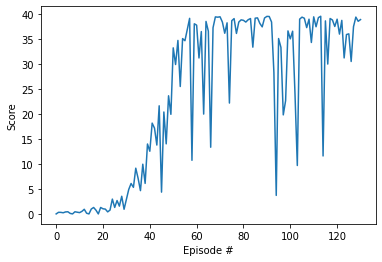


Environment solved in 30 episodes!	Average Score: 30.18


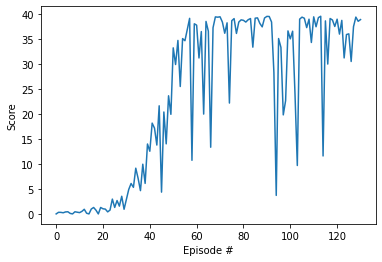

In [11]:
if train_mode:

    #TRAINING ALGORITHM
    
    scores = []                        # list containing scores from each episode
    
    scores_window = deque(maxlen=100)  # last 100 scores

    for each_iteration in range(num_epochs):

        score = 0
        update_step = 0

        env_info=env.reset(train_mode=True)[brain_name]

        state = env_info.vector_observations[0]
        
        for each_environment_step in range(num_steps_per_epoch):

            #sample action from the policy
            action = policy.get_action(state)            

            env_info = env.step(action)[brain_name]

            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            score += reward
            done = env_info.local_done[0]                  # see if episode has finished

            #Store the transition in the replay pool
            replay_buffer.add(state, action, reward, next_state, done)

            if (replay_buffer.buffer_len() > batch_size) and (each_iteration +1 >episods_before_learning): # and (each_environment_step % update_every == 0):            
                update_step+=1
                update()

            state = next_state

            if done or each_environment_step == num_steps_per_epoch - 1:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save all the scores
        
        if each_iteration % 1 ==0:
            clear_output(wait=True)
            
            if auto_entropy_tuning:
                print('\rEpisode {}\tLast Score: {:.2f}; average score: {:.2f}; alpha: {:.4f}'.format(each_iteration, score,np.mean(scores_window),alpha.detach().item()), end="")
            else:
                print('\rEpisode {}\tLast Score: {:.2f}; average score: {:.2f}; alpha: {:.4f}'.format(each_iteration, score,np.mean(scores_window),alpha), end="")
                
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(++len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()

        if score > solve_score and first_30==0:
            first_30 = each_iteration

        if np.mean(scores_window)>=solve_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(each_iteration-100, np.mean(scores_window)))
            break         

    env.close()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [12]:
if train_mode and save_mode:
    torch.save(qf1.state_dict(), 'checkpoint_qf1.pth')
    torch.save(qf2.state_dict(), 'checkpoint_qf2.pth')
    torch.save(policy.state_dict(), 'checkpoint_policy.pth')

In [13]:
#SAVE DATA INTO CSV FILE FOR FURTHER ANALYSIS

In [14]:
if train_mode:
    import csv
    from datetime import datetime

    now = datetime.now() 
    experience_name = "SAC FV - Final"
    date_time = str(now.strftime("%d-%m-%Y %H:%M:%S"))

    all_scores = np.asarray(scores)

    solved_ep = each_iteration - 100
    first_above_30 = first_30

    total_points = all_scores.sum()
    variance = np.var(all_scores)
    scores_per_episod = all_scores.mean()

    with open('reacher_results_final.csv', mode='a') as results_file:
        results_writer = csv.writer(results_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        results_writer.writerow([experience_name, date_time, solved_ep, first_30, scores_per_episod, variance, all_scores])

# Watch the REACHER!

In [15]:
if not train_mode:

    states = env_info.vector_observations                  # get the current state (for each agent)
    t_step=0
    rewards_history=[]
    nb_episodes = 10
    
    for episodes in range (nb_episodes):

        scores = np.zeros(num_agents) # initialize the score (for each agent) 
        t_step=0
        while True:
            actions = policy.get_action2(states)                # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            t_step+=1
            rewards_history.append(rewards)
            if np.all(dones) or t_step>2000:                   # exit loop if episode finished
                break
        print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    print ('Total score: {}'.format(np.sum(rewards_history)))
    env.close()